# Text and multimedia mining project
## Research question
To what extent do reviews from well-known film critics represent the opinion of the average movie viewer?

## Dataset
https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset?select=rotten_tomatoes_critic_reviews.csv 

# Imports

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pickle
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eldik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eldik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eldik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\eldik\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Data retrieval


In [ ]:
!wget -nc https://transfer.sh/pYLJf7/rotten_tomatoes_critic_reviews.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
df = pd.read_csv('rotten_tomatoes_critic_reviews.csv')[['top_critic', 'review_score', 'rotten_tomatoes_link', 'review_content']]
print(df)

         top_critic review_score rotten_tomatoes_link  \
0             False          NaN            m/0814255   
1             False          NaN            m/0814255   
2             False          NaN            m/0814255   
3             False        3.5/5            m/0814255   
4              True          NaN            m/0814255   
...             ...          ...                  ...   
1130012       False          2/5          m/zulu_dawn   
1130013       False        3.5/5          m/zulu_dawn   
1130014       False           B+          m/zulu_dawn   
1130015       False        3.5/5          m/zulu_dawn   
1130016       False            C          m/zulu_dawn   

                                            review_content  
0        A fantasy adventure that fuses Greek mythology...  
1        Uma Thurman as Medusa, the gorgon with a coiff...  
2        With a top-notch cast and dazzling special eff...  
3        Whether audiences will get behind The Lightnin...  
4        W

# Data processing
In the dataset there some value are not filled in, those will be removed. Furthermore, the reviews containing characters not used in normal texts will be removed.

In [ ]:
df = df.dropna()

def create_mask_special_char(df):
    regexpr = re.compile(r'\@|\#|\$|\%|\^|\*|\||\<|\>|\/')
    mask = []
    for review in df['review_content']:
        if regexpr.search(review) == None:
            mask.append(True)
        else:
            mask.append(False)
    return mask

df = df[create_mask_special_char(df)]

For the review_score several scoring methods are used. To fix this issue all scores will be conversed to a value between 1 and 10 or if that is not possible the reviews will be removed.

In [ ]:
def convert_score(score):
    # check if score is a single number
    # with single numbers the scale is unknown, so those scores are set to None
    if score.isnumeric():
        return None

    # check if score looks like 'a/b'
    elif '/' in score:
        a, b = score.split('/')
        # check if score looks like 'a/0'
        if float(b) in [5.0, 10.0, 100.0]:
            score = round(5 * float(a) / float(b))
            if score == 0 or score > 5:
                return None
            else:
                return score
        else:
            return None

    # score is letter based
    else:
        if 'A' in score:
            return 5
        elif 'B' in score:
            return 4
        elif 'C' in score:
            return 3
        elif 'D' in score:
            return 2
        elif 'F' in score:
            return 1
        else: 
            return None

df['review_score'] = df['review_score'].map(convert_score)
df = df.dropna()
df['review_score'] = df['review_score'].astype('int16')

The column rotten_tomatoes_link contains an id to the information over the movie that is reviewed. This can be used as a feature for the review. So this information will be conversed to a unique integer value for every movie.

In [ ]:
df['rotten_tomatoes_link'] = df['rotten_tomatoes_link'].astype('category').cat.codes
df['review_content'] = df['review_content'].astype('string')
print(df.dtypes)

top_critic                bool
review_score             int16
rotten_tomatoes_link     int16
review_content          string
dtype: object


The dataset is quite big and we want an equal distribution from top critics and not top critics, so we select random reviews from the set.

In [ ]:
df = pd.concat([df[df['top_critic']].sample(n=50000, random_state = 1), df[~df['top_critic']].sample(n=50000, random_state = 1)])
df = df.reset_index(drop = True)
print(df)

       top_critic  review_score  rotten_tomatoes_link  \
0            True             4                  6525   
1            True             4                 16910   
2            True             1                 12357   
3            True             2                  4661   
4            True             2                  7004   
...           ...           ...                   ...   
99995       False             2                  5122   
99996       False             4                  1597   
99997       False             4                 14609   
99998       False             1                 13345   
99999       False             4                  4284   

                                          review_content  
0      The film will probably end up preaching to the...  
1      Radcliffe is delightful, showcasing a sly, win...  
2      Even though the once-and-forever Dude abides b...  
3      Coco and Igor manages to drag this sorry, unse...  
4      By the end, w

# Extracting features
Before the features are extracted, the text is preprocessed to reduce the amount of features. The words in the reviews will be marked with Parts of Speech Tagging. Then the words with the right tags will be kept and some extra important words. Furthermore, all words will be converted to lower case and stopwords will be removed.

In [ ]:
def reduce_features(df):
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    wanted_tags = ["ADJ", "ADV", "verb"]
    wanted_words = ["neither", "no", "n't", "not", "nor", "none", "nobody", "although", "however", "pro", "anti", "despite", "nonetheless", "nevertheless", "but"]
    reviews = []
    for review in df['review_content']:
        words = word_tokenize(review)
        tagged_words = nltk.pos_tag(words, tagset='universal')
        words = []
        for word, tag in tagged_words:
            word = word.lower()
            if word in wanted_words or tag in wanted_tags and word not in stop_words and "-" not in word:
                words.append(word)
        reviews.append(" ".join(words))
    df['review_content'] = reviews
    return df
    
df = reduce_features(df)
print(df)

       top_critic  review_score  rotten_tomatoes_link  \
0            True             4                  6525   
1            True             4                 16910   
2            True             1                 12357   
3            True             2                  4661   
4            True             2                  7004   
...           ...           ...                   ...   
99995       False             2                  5122   
99996       False             4                  1597   
99997       False             4                 14609   
99998       False             1                 13345   
99999       False             4                  4284   

                                          review_content  
0                                  probably surprisingly  
1      delightful sly comedic bit twee also undefined...  
2                                               even n't  
3                   unseemly yet hardly earth barely n't  
4                   

In [ ]:
def extract_TF_IDF(df):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(df['review_content'].tolist())
    vector = vectorizer.transform(df['review_content'].tolist())
    return vector

vector = extract_TF_IDF(df)
print(vector.shape)

(100000, 13540)


# Splitting the dataset
To train the models, the dataset has to be split up in a training and test sets. Furthermore the dataset has to be split up in reviews from top critics and reviews from not top critics. So in total there will be six sets.

In [ ]:
# split top critics and not top critics
tc_df = df[df['top_critic']]
ntc_df = df[~df['top_critic']]

# split train and test set
tc_df_train, tc_df_test = train_test_split(tc_df , random_state=1, shuffle=True)
ntc_df_train, ntc_df_test = train_test_split(ntc_df , random_state=1, shuffle=True)

# Training the models

In [ ]:
def get_features(data_set, vector):
    features = []
    for row in data_set.index.values:
        features.append(np.append(vector.getrow(row).toarray(), data_set['rotten_tomatoes_link'][row]))
    return features

In [ ]:
tc_model = svm.SVC()
tc_model.fit(get_features(tc_df_train, vector), list(tc_df_train['review_score']))
pickle.dump(tc_model, open("tc_model.sav", 'wb'))

In [ ]:
ntc_model = svm.SVC()
ntc_model.fit(get_features(ntc_df_train, vector), list(ntc_df_train['review_score']))
pickle.dump(ntc_model, open("ntc_model.sav", 'wb'))

In [ ]:
tc_model = pickle.load(open("tc_model.sav", 'rb'))
ntc_model = pickle.load(open("ntc_model.sav", 'rb'))

In [ ]:
tc_features = get_features(tc_df_test, vector)
tc_predictions = tc_model.predict(tc_features)
pickle.dump(tc_predictions, open("tc_predictions.sav", 'wb'))

In [ ]:
tc_predictions = pickle.load(open("tc_predictions.sav", 'rb'))

In [ ]:
ntc_features = get_features(ntc_df_test, vector)
ntc_predictions = ntc_model.predict(ntc_features)
pickle.dump(ntc_predictions, open("ntc_predictions.sav", 'wb'))

In [ ]:
ntc_predictions = pickle.load(open("ntc_predictions.sav", 'rb'))

In [ ]:
tc_fscore = f1_score(tc_df_test['review_score'], tc_predictions, average='weighted')
tc_accuracy = accuracy_score(tc_df_test['review_score'], tc_predictions)
tc_recall = recall_score(tc_df_test['review_score'], tc_predictions, average='weighted')
tc_precision = precision_score(tc_df_test['review_score'], tc_predictions, average='weighted')
print("F1-score top critic model: ", tc_fscore)
print("Accuracy top critic model: ", tc_accuracy)
print("Recall top critic model: ", tc_recall)
print("Precision top critic model: ", tc_precision)

F1-score top critic model:  0.19301909469852638
Accuracy top critic model:  0.36264
Recall top critic model:  0.36264
Precision top critic model:  0.13150776960000002


C:\Users\eldik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ntc_fscore = f1_score(ntc_df_test['review_score'], ntc_predictions, average='weighted')
ntc_accuracy = accuracy_score(ntc_df_test['review_score'], ntc_predictions)
ntc_recall = recall_score(ntc_df_test['review_score'], ntc_predictions, average='weighted')
ntc_precision = precision_score(ntc_df_test['review_score'], ntc_predictions, average='weighted')
print("F1-score not top critic model: ", ntc_fscore)
print("Accuracy not top critic model: ", ntc_accuracy)
print("Recall not top critic model: ", ntc_recall)
print("Precision not top critic model: ", ntc_precision)

F1-score not top critic model:  0.25819272523782877
Accuracy not top critic model:  0.4296
Recall not top critic model:  0.4296
Precision not top critic model:  0.18455615999999997


C:\Users\eldik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Running the models on the other datasets

In [ ]:
tc_on_ntc_model_predictions = ntc_model.predict(tc_features)
pickle.dump(tc_on_ntc_model_predictions, open("tc_on_ntc_model_predictions.sav", 'wb'))

In [ ]:
tc_on_ntc_model_predictions = pickle.load(open("tc_on_ntc_model_predictions.sav", 'rb'))

In [ ]:
ntc_on_tc_model_predictions = tc_model.predict(ntc_features)
pickle.dump(ntc_on_tc_model_predictions, open("ntc_on_tc_model_predictions.sav", 'wb'))

In [ ]:
ntc_on_tc_model_predictions = pickle.load(open("ntc_on_tc_model_predictions.sav", 'rb'))

In [ ]:
tc_on_ntc_model_fscore = f1_score(tc_df_test['review_score'], tc_on_ntc_model_predictions, average='weighted')
tc_on_ntc_model_accuracy = accuracy_score(tc_df_test['review_score'], tc_on_ntc_model_predictions)
tc_on_ntc_model_recall = recall_score(tc_df_test['review_score'], tc_on_ntc_model_predictions, average='weighted')
tc_on_ntc_model_precision = precision_score(tc_df_test['review_score'], tc_on_ntc_model_predictions, average='weighted')
print("F1-score not top critic model on top critic dataset: ", tc_on_ntc_model_fscore)
print("Accuracy not top critic model on top critic dataset: ", tc_on_ntc_model_accuracy)
print("Recall not top critic model on top critic dataset: ", tc_on_ntc_model_recall)
print("Precision not top critic model on top critic dataset: ", tc_on_ntc_model_precision)

F1-score not top critic model on top critic dataset:  0.19301909469852638
Accuracy not top critic model on top critic dataset:  0.36264
Recall not top critic model on top critic dataset:  0.36264
Precision not top critic model on top critic dataset:  0.13150776960000002


C:\Users\eldik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ntc_on_tc_model_fscore = f1_score(ntc_df_test['review_score'], ntc_on_tc_model_predictions, average='weighted')
ntc_on_tc_model_accuracy = accuracy_score(ntc_df_test['review_score'], ntc_on_tc_model_predictions)
ntc_on_tc_model_recall = recall_score(ntc_df_test['review_score'], ntc_on_tc_model_predictions, average='weighted')
ntc_on_tc_model_precision = precision_score(ntc_df_test['review_score'], ntc_on_tc_model_predictions, average='weighted')
print("F1-score not top critic model on top critic dataset: ", ntc_on_tc_model_fscore)
print("Accuracy not top critic model on top critic dataset: ", ntc_on_tc_model_accuracy)
print("Recall not top critic model on top critic dataset: ", ntc_on_tc_model_recall)
print("Precision not top critic model on top critic dataset: ", ntc_on_tc_model_precision)

F1-score not top critic model on top critic dataset:  0.25819272523782877
Accuracy not top critic model on top critic dataset:  0.4296
Recall not top critic model on top critic dataset:  0.4296
Precision not top critic model on top critic dataset:  0.18455615999999997


C:\Users\eldik\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluation

In [ ]:
print("Average of top critic scores:", sum(tc_df_test['review_score']) / len(tc_df_test['review_score']))
print("Average of not top critic scores:", sum(ntc_df_test['review_score']) / len(ntc_df_test['review_score']))

Average of top critic scores: 3.18712
Average of not top critic scores: 3.32112


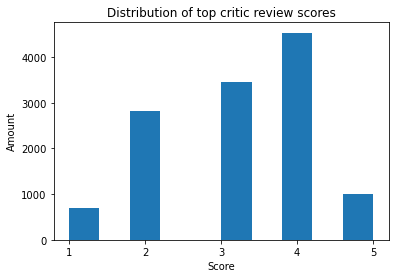

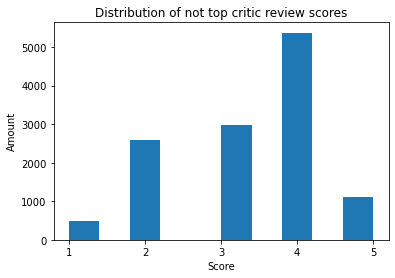

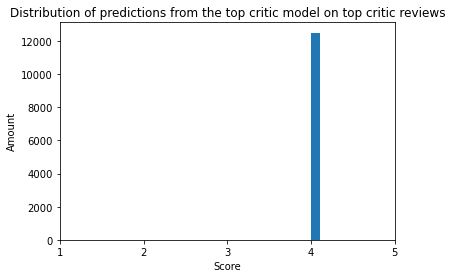

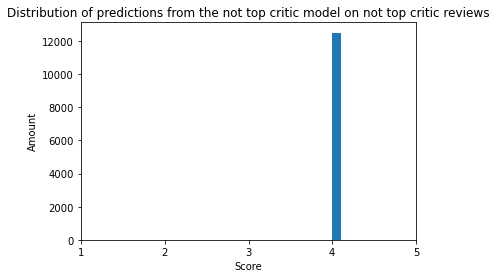

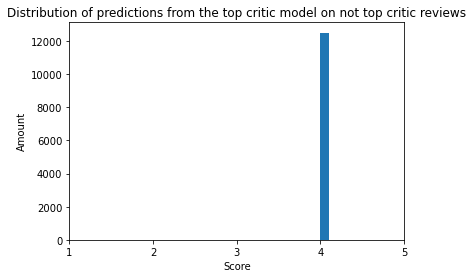

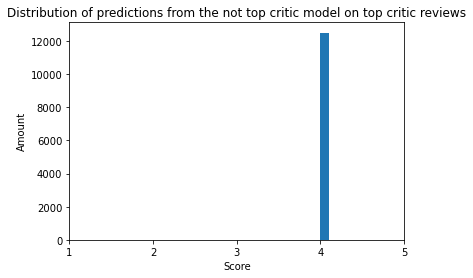

In [ ]:
plt.hist(tc_df_test['review_score'])
plt.title("Distribution of top critic review scores")
plt.xlabel("Score")
plt.ylabel("Amount")
plt.xticks([1,2,3,4,5])
plt.show()

plt.hist(ntc_df_test['review_score'])
plt.title("Distribution of not top critic review scores")
plt.xlabel("Score")
plt.ylabel("Amount")
plt.xticks([1,2,3,4,5])
plt.show()

plt.hist(tc_predictions)
plt.title("Distribution of predictions from the top critic model on top critic reviews")
plt.xlabel("Score")
plt.ylabel("Amount")
plt.xticks([1,2,3,4,5])
plt.show()

plt.hist(ntc_predictions)
plt.title("Distribution of predictions from the not top critic model on not top critic reviews")
plt.xlabel("Score")
plt.ylabel("Amount")
plt.xticks([1,2,3,4,5])
plt.show()

plt.hist(tc_on_ntc_model_predictions)
plt.title("Distribution of predictions from the top critic model on not top critic reviews")
plt.xlabel("Score")
plt.ylabel("Amount")
plt.xticks([1,2,3,4,5])
plt.show()

plt.hist(ntc_on_tc_model_predictions)
plt.title("Distribution of predictions from the not top critic model on top critic reviews")
plt.xlabel("Score")
plt.ylabel("Amount")
plt.xticks([1,2,3,4,5])
plt.show()